# Explaining RL Decisions with Trajectories

This file contains code used for generating results of the gridworld experiments. In this notebook we investigate additional research questions and extensions to verify further some of the claims. We aim to gain further insights in the usefulness of the use of trajectories

In [37]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment
from env import idx_to_coords


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


torch.backends.cudnn.deterministic=True
torch.cuda.manual_seed_all(0)
random.seed(0)


### Instantiate the Environment

We provide one 11x11 environment. An agent may be able to start from any position. We adapt the 4x4 environment from the code provided by the authors.

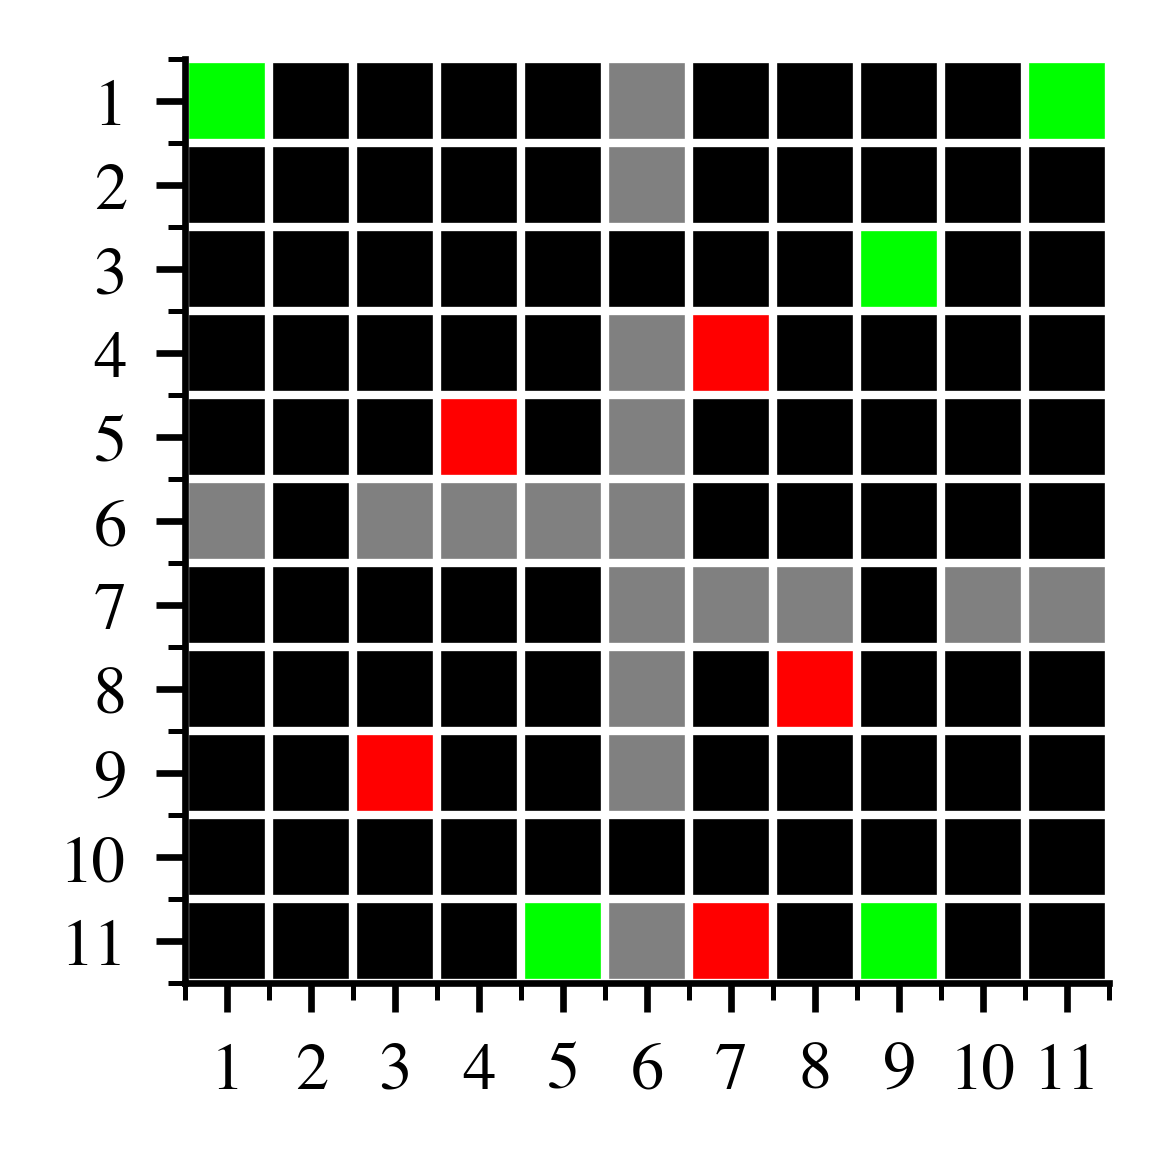

In [38]:

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}
obstacle=[[0, 5], [1, 5], [3, 5], [4, 5], [5, 0], [5, 2], [5, 3], [5, 4], [5, 5], [6, 5], [7, 5], [8, 5], [10, 5], [6, 6], [6, 7], [6, 9], [6, 10]]
terminal = {(0, 0): +1, (0, 10): +1, (4, 3): -1, (8, 2):-1, (2, 8):+1, (3, 6):-1, (7,7):-1, (10, 6):-1, (10, 4):+1, (10, 8):+1}
start = []
for i in range(11):
    for j in range(11):
        if (i,j) not in terminal.keys() and [i,j] not in obstacle:
            start.append((i,j))

# # Environment Definition
env_width = 11
env_height = 11
env = Environment(dim=(env_width, env_height),
                   starts= start,
                   terminals= terminal,
                   obstacles=obstacle,
                   stoc=0.)

env.render(title='Edited Gridworld Environment')

# # Initialize the agent
agent = Agent(env)

# #####

### Collecting offline trajectory data

In [39]:
# Generate offline data for the training
num_episodes_dyna = 5
num_agents_dyna = 10
max_traj_len = 12
num_pos_trajs = 250
num_neg_trajs = 50
#offline_data11 = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

In [40]:
#If you are planning to pickle these trajectories and use them instead of generating them every time...
results_save_dir = './gridworld_results/grid_11by11/'
#with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'wb') as f:
    #pickle.dump(offline_data11, f)

with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'rb') as f:
       offline_data11 = pickle.load(f)

## Sequential Encoder

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

In [41]:
def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

tokenized_data = tokenizer(offline_data11, 
                          state_space_dim = env_width*env_height, 
                          action_dict = action_dict, 
                          reward_dict = reward_dict, 
                          max_traj_len = max_traj_len)

In [42]:
class LSTMEncoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)

    def forward(self, traj):
        embeds = self.token_embeddings(traj)
        o, (h_n, c_n) = self.lstm(embeds.view(len(traj), 1, -1)) # Batch first is false, -> Input shape (L(seq len), N(num seq), H_in(hidden size))
        # The LSTM output contains :
        # o - Outputs of individual cells : shape (L, N, H)
        # h_n - Final hidden state
        # c_n - Final cell state
        return o[-1], (h_n, c_n)
    
class LSTMDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_size,
                                      )

        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden_state, cell_state):
        # Input is START TOKEN
        # Hidden state, Cell state are taken from encoder's output

        # Get embedding
        embedded = self.embedding(input)        
        output = embedded.view(len(input), 1, -1)
        
        # Run LSTM to decode the trajectory
        output, _ = self.lstm(output, (hidden_state, cell_state))
        
        # Convert LSTM logits to vocab size softmax 
        out = self.out(output.squeeze(1))
        output = F.log_softmax(out, dim=1)
        
        return output

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, traj):
        traj_embedding = self.encoder(traj[1:])
        decoded_traj = self.decoder(traj[:-1], traj_embedding[1][0], traj_embedding[1][1])
        return decoded_traj, traj_embedding

traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)


## Training LSTM to encode trajectories in a seq2seq setting

In [43]:
# Hyperparameters 
num_epochs = 25

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [44]:
model.train()

for epoch_id, epoch in enumerate(range(num_epochs)):
    total_loss = 0
    for traj_id, traj in enumerate(tokenized_data):
        optimizer.zero_grad()
        
        # Get decoded trajectory and its embedding
        decoded_traj, traj_embedding = model(traj)
        # Loss
        loss = F.nll_loss(decoded_traj.view(-1, vocab_size),
                          traj[1:].contiguous().view(-1),
                          ignore_index=0)
        
        # Optimize the model
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # Record loss
        total_loss += loss.data.item()

    total_loss = total_loss / 100
    
    print(f'Epoch: {epoch_id + 1}, Loss:{total_loss}')

Epoch: 1, Loss:5.28290723964572
Epoch: 2, Loss:3.4738932171836496
Epoch: 3, Loss:2.868315411657095
Epoch: 4, Loss:2.464435528293252
Epoch: 5, Loss:2.2696165707707405
Epoch: 6, Loss:2.1077058584988118
Epoch: 7, Loss:2.0012438725680113
Epoch: 8, Loss:1.9000826289504766
Epoch: 9, Loss:1.8487556172162294
Epoch: 10, Loss:1.7473223852366209
Epoch: 11, Loss:1.6920702686905862
Epoch: 12, Loss:1.6564842758327722
Epoch: 13, Loss:1.6285945789515972
Epoch: 14, Loss:1.6431585371494293
Epoch: 15, Loss:1.5871981216967106
Epoch: 16, Loss:1.55235299564898
Epoch: 17, Loss:1.5322234457731247
Epoch: 18, Loss:1.5585397797077893
Epoch: 19, Loss:1.5288038950413465
Epoch: 20, Loss:1.493705121204257
Epoch: 21, Loss:1.491596540659666
Epoch: 22, Loss:1.462003763690591
Epoch: 23, Loss:1.462881678789854
Epoch: 24, Loss:1.4867605454474688
Epoch: 25, Loss:1.5121648220717907


In [45]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')

## Trajectory Attribution 

Starts here...

In [46]:
# Load the trained model
traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_5.pth'))
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_fourrooms.pth'))
model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_7.pth'))

<All keys matched successfully>

### Encode trajectories in the offline dataset

In [47]:
# Load and generate trajectory embeddings
traj_embeddings = []

for traj_id, traj in enumerate(tokenized_data):
    with torch.no_grad():
        decoded_traj, traj_embedding = model(traj)
        traj_embeddings.append(torch.cat(traj_embedding[1], axis=-1).numpy().reshape(-1))
        

The cell below can be bugged sometimes. It is part of the code of the authors. Just run it again if necessary. We use the x-means algorithm

In [48]:

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
np.random.seed(0)
from sklearn.cluster import DBSCAN
method = 'db'
if method == 'xcluster':
    amount_initial_centers = 2
    initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers, random_state = 0).initialize()
    
    # Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
    # number of clusters that can be allocated is 10.
    xmeans_instance = xmeans(traj_embeddings, initial_centers, 10, random_state=99)
    xmeans_instance.process()
    
    # Extract clustering results: clusters and their centers
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    
    # Print total sum of metric errors
    print("Total WCE:", xmeans_instance.get_total_wce())
    print("Clusters:", clusters)
    print('Number of clusters', len(clusters))

elif method == 'db':
    
    amount_initial_centers = 2


    dbscan = DBSCAN(eps=2.04, min_samples=2).fit(traj_embeddings)
    clustering_labels = dbscan.labels_


    clusters_dict = {}
    for i, label in enumerate(clustering_labels):
        if label not in clusters_dict:
            clusters_dict[label] = [i]
        else:
            clusters_dict[label].append(i)

    clusters = list(clusters_dict.values())

    # Print total sum of metric errors
    print("Clusters:", clusters)
    print("Cluster Labels:", clustering_labels)
    print('Number of clusters:', len(clusters))

else:
    raise NotImplementedError
    

Clusters: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299], [178, 179, 180, 181, 1

In [ ]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id


## Encode sets of trajectories

In [49]:
def get_data_embedding(traj_embeddings):
    # Normalize traj_embeddings to mitigate extremely large values
    traj_embeddings = np.array(traj_embeddings)
    traj_embeddings_max = np.max(traj_embeddings, axis=1, keepdims=True)
    traj_embeddings = traj_embeddings - traj_embeddings_max
    
    # Sum the normalized embeddings
    traj_embeddings_sum = traj_embeddings.sum(axis=0) / len(clusters)
    
    # Apply the Log-Sum-Exp trick
    max_val = np.max(traj_embeddings_sum)
    stabilized_exp = np.exp(traj_embeddings_sum - max_val)
    
    # Compute the normalized exponential values
    data_embedding = stabilized_exp / np.sum(stabilized_exp)
    return data_embedding

data_embedding = get_data_embedding(traj_embeddings)

print(data_embedding)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0104664e-34 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


### Train models on different cluster combinations

In [50]:
transition_model, reward_model = generate_model(env, offline_data11)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [51]:
result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data11):
        if traj_id not in cluster:
            temp_data.append(offline_data11[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

### Generate attributions

In [52]:
attributions = []


for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals or [state//env_width, state%env_width] in env.obstacles:
        continue
    

    orig_state_action_values = action_values[state]
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)
    
    responsible_data_combination = np.argsort(distances)[0]
    
    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    if (state//env_width, state%env_width) in env.terminals or [state//env_width, state%env_width] in env.obstacles:
        assert False
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data11), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

----------
State - (4, 1)
Distance - 1.8424329247395387e-35
Original Actions -['LEFT']
New Action - ['RIGHT']
Responsible data combination - data id 10
Responsible trajectory id [242, 243, 244, 245, 249, 250, 252, 253]
----------
----------
State - (5, 1)
Distance - 1.8424329247395387e-35
Original Actions -['LEFT']
New Action - ['DOWN']
Responsible data combination - data id 10
Responsible trajectory id [242, 243, 244, 245, 249, 250, 252, 253]
----------
----------
State - (3, 2)
Distance - 3.4523617625599713e-37
Original Actions -['UP']
New Action - ['LEFT']
Responsible data combination - data id 7
Responsible trajectory id [231]
----------
----------
State - (4, 2)
Distance - 3.4523617625599713e-37
Original Actions -['LEFT']
New Action - ['DOWN']
Responsible data combination - data id 7
Responsible trajectory id [231]
----------
----------
State - (5, 2)
Distance - 1.8424329247395387e-35
Original Actions -['UP']
New Action - ['LEFT']
Responsible data combination - data id 10
Responsi

In [53]:
attributions

[{'state': (4, 1),
  'orig_act': ['LEFT'],
  'new_act': ['RIGHT'],
  'attributed_trajs': [242, 243, 244, 245, 249, 250, 252, 253],
  'random_baseline_trajs': [174, 148, 29, 67, 35],
  'alternate_cluster_trajs': [231],
  'responsible_cluster': 9},
 {'state': (5, 1),
  'orig_act': ['LEFT'],
  'new_act': ['DOWN'],
  'attributed_trajs': [242, 243, 244, 245, 249, 250, 252, 253],
  'random_baseline_trajs': [73, 297, 218, 259, 287],
  'alternate_cluster_trajs': [231],
  'responsible_cluster': 9},
 {'state': (3, 2),
  'orig_act': ['UP'],
  'new_act': ['LEFT'],
  'attributed_trajs': [231],
  'random_baseline_trajs': [61, 44, 290, 88, 33],
  'alternate_cluster_trajs': [233,
   234,
   235,
   236,
   237,
   238,
   239,
   240,
   254,
   255,
   256],
  'responsible_cluster': 6},
 {'state': (4, 2),
  'orig_act': ['LEFT'],
  'new_act': ['DOWN'],
  'attributed_trajs': [231],
  'random_baseline_trajs': [232, 255, 36, 256, 290],
  'alternate_cluster_trajs': [218, 219, 220, 221, 222, 223, 258, 259]

In [54]:
if False:
    target_state = (10, 8)
    selected_list = [item for item in attributions if item['state'] == (target_state)]

    for i in range(len(selected_list[0]['attributed_trajs'])):
        env.plot_traj(offline_data[selected_list[0]['attributed_trajs'][i]])
else:
    pass
    



In [55]:
results_save_dir = './gridworld_results/grid_7by7/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [56]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [57]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

In [58]:
attributions

[{'state': (4, 1),
  'orig_act': ['LEFT'],
  'new_act': ['RIGHT'],
  'attributed_trajs': [242, 243, 244, 245, 249, 250, 252, 253],
  'random_baseline_trajs': [174, 148, 29, 67, 35],
  'alternate_cluster_trajs': [231],
  'responsible_cluster': 9},
 {'state': (5, 1),
  'orig_act': ['LEFT'],
  'new_act': ['DOWN'],
  'attributed_trajs': [242, 243, 244, 245, 249, 250, 252, 253],
  'random_baseline_trajs': [73, 297, 218, 259, 287],
  'alternate_cluster_trajs': [231],
  'responsible_cluster': 9},
 {'state': (3, 2),
  'orig_act': ['UP'],
  'new_act': ['LEFT'],
  'attributed_trajs': [231],
  'random_baseline_trajs': [61, 44, 290, 88, 33],
  'alternate_cluster_trajs': [233,
   234,
   235,
   236,
   237,
   238,
   239,
   240,
   254,
   255,
   256],
  'responsible_cluster': 6},
 {'state': (4, 2),
  'orig_act': ['LEFT'],
  'new_act': ['DOWN'],
  'attributed_trajs': [231],
  'random_baseline_trajs': [232, 255, 36, 256, 290],
  'alternate_cluster_trajs': [218, 219, 220, 221, 222, 223, 258, 259]

## Initial State Value Estimates

In [59]:
results = []
for data_combination_id in result_data_combinations:
    # modify the below such that you print them in the order of value, together with a string that says which data combination it is
    temp = result_data_combinations[data_combination_id][0].max(axis=1).mean()
    results.append(temp)
    

#create a dictionary with the data combination id as the key and the value as the value
results_dict = {}
for i in range(len(results)):
    results_dict[i] = results[i]

#sort the dictionary by value
sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=True)


# print the results in order
for i in range(len(sorted_results)):
    print(sorted_results[i])
    

(0, 0.44332855386268)
(3, 0.44332855385999964)
(4, 0.4396586059040094)
(7, 0.4393743756087195)
(6, 0.43860570238383007)
(2, 0.43859771440384204)
(5, 0.43335082124679675)
(10, 0.4307583770727887)
(8, 0.4279891971757072)
(9, 0.4220649234628607)
(1, 0.36410422563212047)


In [60]:
sorted_clusters = sorted(enumerate(clusters, 1), key=lambda x: len(x[1]), reverse=True)

# Formatting the output
output_lenfg = "Clusters in order of length:\n" + "\n".join(
    f"Data id: {idx}, length {len(cluster)}" for idx, cluster in sorted_clusters
)


In [61]:
results = []
for data_combination_id in result_data_combinations:
    # modify the below such that you print them in the order of value, together with a string that says which data combination it is
    temp = result_data_combinations[data_combination_id][0].max(axis=1).mean()
    results.append(temp)



#create a dictionary with the data combination id as the key and the value as the value
results_dict = {}
for i in range(len(results)):
    results_dict[i] = results[i]

el_0 = next(iter(results_dict.items()))


# Create a new dictionary with just the first element
first_element_dict = {el_0[0]: el_0[1]}

# Pop the first element from results_dict
results_dict.pop(el_0[0])
#sort the dictionary by value
sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=True)


# print the results in order
for i in range(len(sorted_results)):
    #print(sorted_results[i])
    pass
    

# Additional Experiments for Claim DTAD

We now want to analyze in a more quantitative way if distance trajectories have influence on our result

First, we need to create a function that calculates the distance from a state to a trajectory. We propose our function

A path is possible from any point of the grid to another. So what we want is to find the shortest path between two points in the grid given a set of obstacles. 

In [62]:
import numpy as np
import heapq

def manhattan_distance(start, goal):
    return abs(start[0] - goal[0]) + abs(start[1] - goal[1])

def a_star_search(environment, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: manhattan_distance(start, goal)}

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return  len(path)  
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]: 
            neighbor = (current[0] + dx, current[1] + dy)
            if not environment.is_valid_move(*neighbor):
                continue

            tentative_g_score = g_score[current] + 1
            if tentative_g_score < g_score.get(neighbor, float("inf")):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + manhattan_distance(neighbor, goal)
                if neighbor not in [i[1] for i in open_set]:
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return 0  # if not finding path just do 0 -> design choice!


#chekcing it
length = a_star_search(env, (0,0), (0,0))
print(length)



0


In [63]:
def idx_to_coords_attr(idx, grid_dim=(6, 9)):
    """Get co-ordinates from given index"""
    return (idx // grid_dim[1]) , (idx % grid_dim[1]) 

In [64]:
database_length_distances = {}
database_far_traj = {}

for x in attributions:
    #print(x['state'])
    temp_big = []
    count = 0
    
    for i in range (len(x['attributed_trajs'])):
       
        temp_small = []
        for j in range(len(offline_data11[x['attributed_trajs'][i]])):
            #print(offline_data11[x['attributed_trajs'][i]][j][0])
            start_point = idx_to_coords_attr(offline_data11[x['attributed_trajs'][i]][j][0], env.dim)
            #print(start_point)
            end_point = x['state']
            end_point = (end_point[1]-1, end_point[0]-1)
            
            path_l = a_star_search(env, start_point, end_point)
            
            #check if the trajectory from 
            temp_small.append(path_l)
        #check if there is any 0 in temp_small
        if 0 in temp_small:
            temp_big.append(0)
            
        else:
            count += 1
            temp_big.append(np.mean(temp_small))
    if 0 in temp_big:
        database_length_distances[x['state']] = np.mean(temp_big)
    else:
        database_length_distances[x['state']] = np.mean(temp_big)
    database_far_traj[x['state']] = count

In [65]:
database_far_traj

{(4, 1): 7,
 (5, 1): 7,
 (3, 2): 0,
 (4, 2): 0,
 (5, 2): 8,
 (2, 3): 7,
 (4, 3): 4,
 (1, 4): 10,
 (2, 4): 214,
 (3, 4): 7,
 (4, 4): 4,
 (5, 4): 4,
 (1, 5): 10,
 (3, 5): 7,
 (5, 5): 4,
 (7, 5): 7,
 (8, 5): 7,
 (9, 6): 8,
 (3, 7): 7,
 (4, 7): 7,
 (9, 7): 10,
 (4, 8): 214,
 (5, 8): 7,
 (7, 8): 211,
 (11, 8): 12,
 (2, 9): 214,
 (7, 9): 5,
 (9, 9): 213,
 (2, 10): 213,
 (3, 10): 212,
 (5, 10): 202,
 (6, 10): 201,
 (7, 10): 4,
 (10, 10): 206,
 (11, 10): 213,
 (1, 11): 8,
 (2, 11): 212,
 (3, 11): 208}

In [66]:
database_length_distances

{(4, 1): 7.292708333333334,
 (5, 1): 7.167708333333334,
 (3, 2): 0.0,
 (4, 2): 0.0,
 (5, 2): 7.0296875,
 (2, 3): 6.671354166666667,
 (4, 3): 9.495000000000001,
 (1, 4): 9.272727272727273,
 (2, 4): 8.946395348837209,
 (3, 4): 6.7515625,
 (4, 4): 10.27,
 (5, 4): 9.495000000000001,
 (1, 5): 10.025974025974026,
 (3, 5): 7.1265625,
 (5, 5): 10.295,
 (7, 5): 7.330729166666666,
 (8, 5): 6.471354166666667,
 (9, 6): 4.551948051948052,
 (3, 7): 10.395833333333332,
 (4, 7): 10.770833333333332,
 (9, 7): 6.032467532467533,
 (4, 8): 11.012253599114064,
 (5, 8): 10.958333333333332,
 (7, 8): 10.20109080841639,
 (11, 8): 7.244755244755244,
 (2, 9): 10.74250830564784,
 (7, 9): 6.081666666666666,
 (9, 9): 8.511190476190476,
 (2, 10): 10.901101882613512,
 (3, 10): 10.644911406423034,
 (5, 10): 9.745631229235881,
 (6, 10): 9.438654485049835,
 (7, 10): 5.6066666666666665,
 (10, 10): 9.807236987818383,
 (11, 10): 10.826483942414175,
 (1, 11): 11.863247863247864,
 (2, 11): 11.785442967884828,
 (3, 11): 11.507

What we obtained is the list with all average lengths. 

In [67]:
average_length = np.mean([x for x in database_length_distances.values()])
print(average_length)


8.480818509995379


In [68]:
total = 0
# for all the states in attributions check how manu are in obstacle
for x in attributions:
    y = list(x['state'])
    z = [y[1]-1, y[0]-1]
    if z in env.obstacles or tuple(z) in env.terminals:
        if z in env.obstacles:
            print(z , 'is in obstacles')
        if tuple(z) in env.terminals:
            print( z , 'is in terminals')
        total += 1
print(total)

0


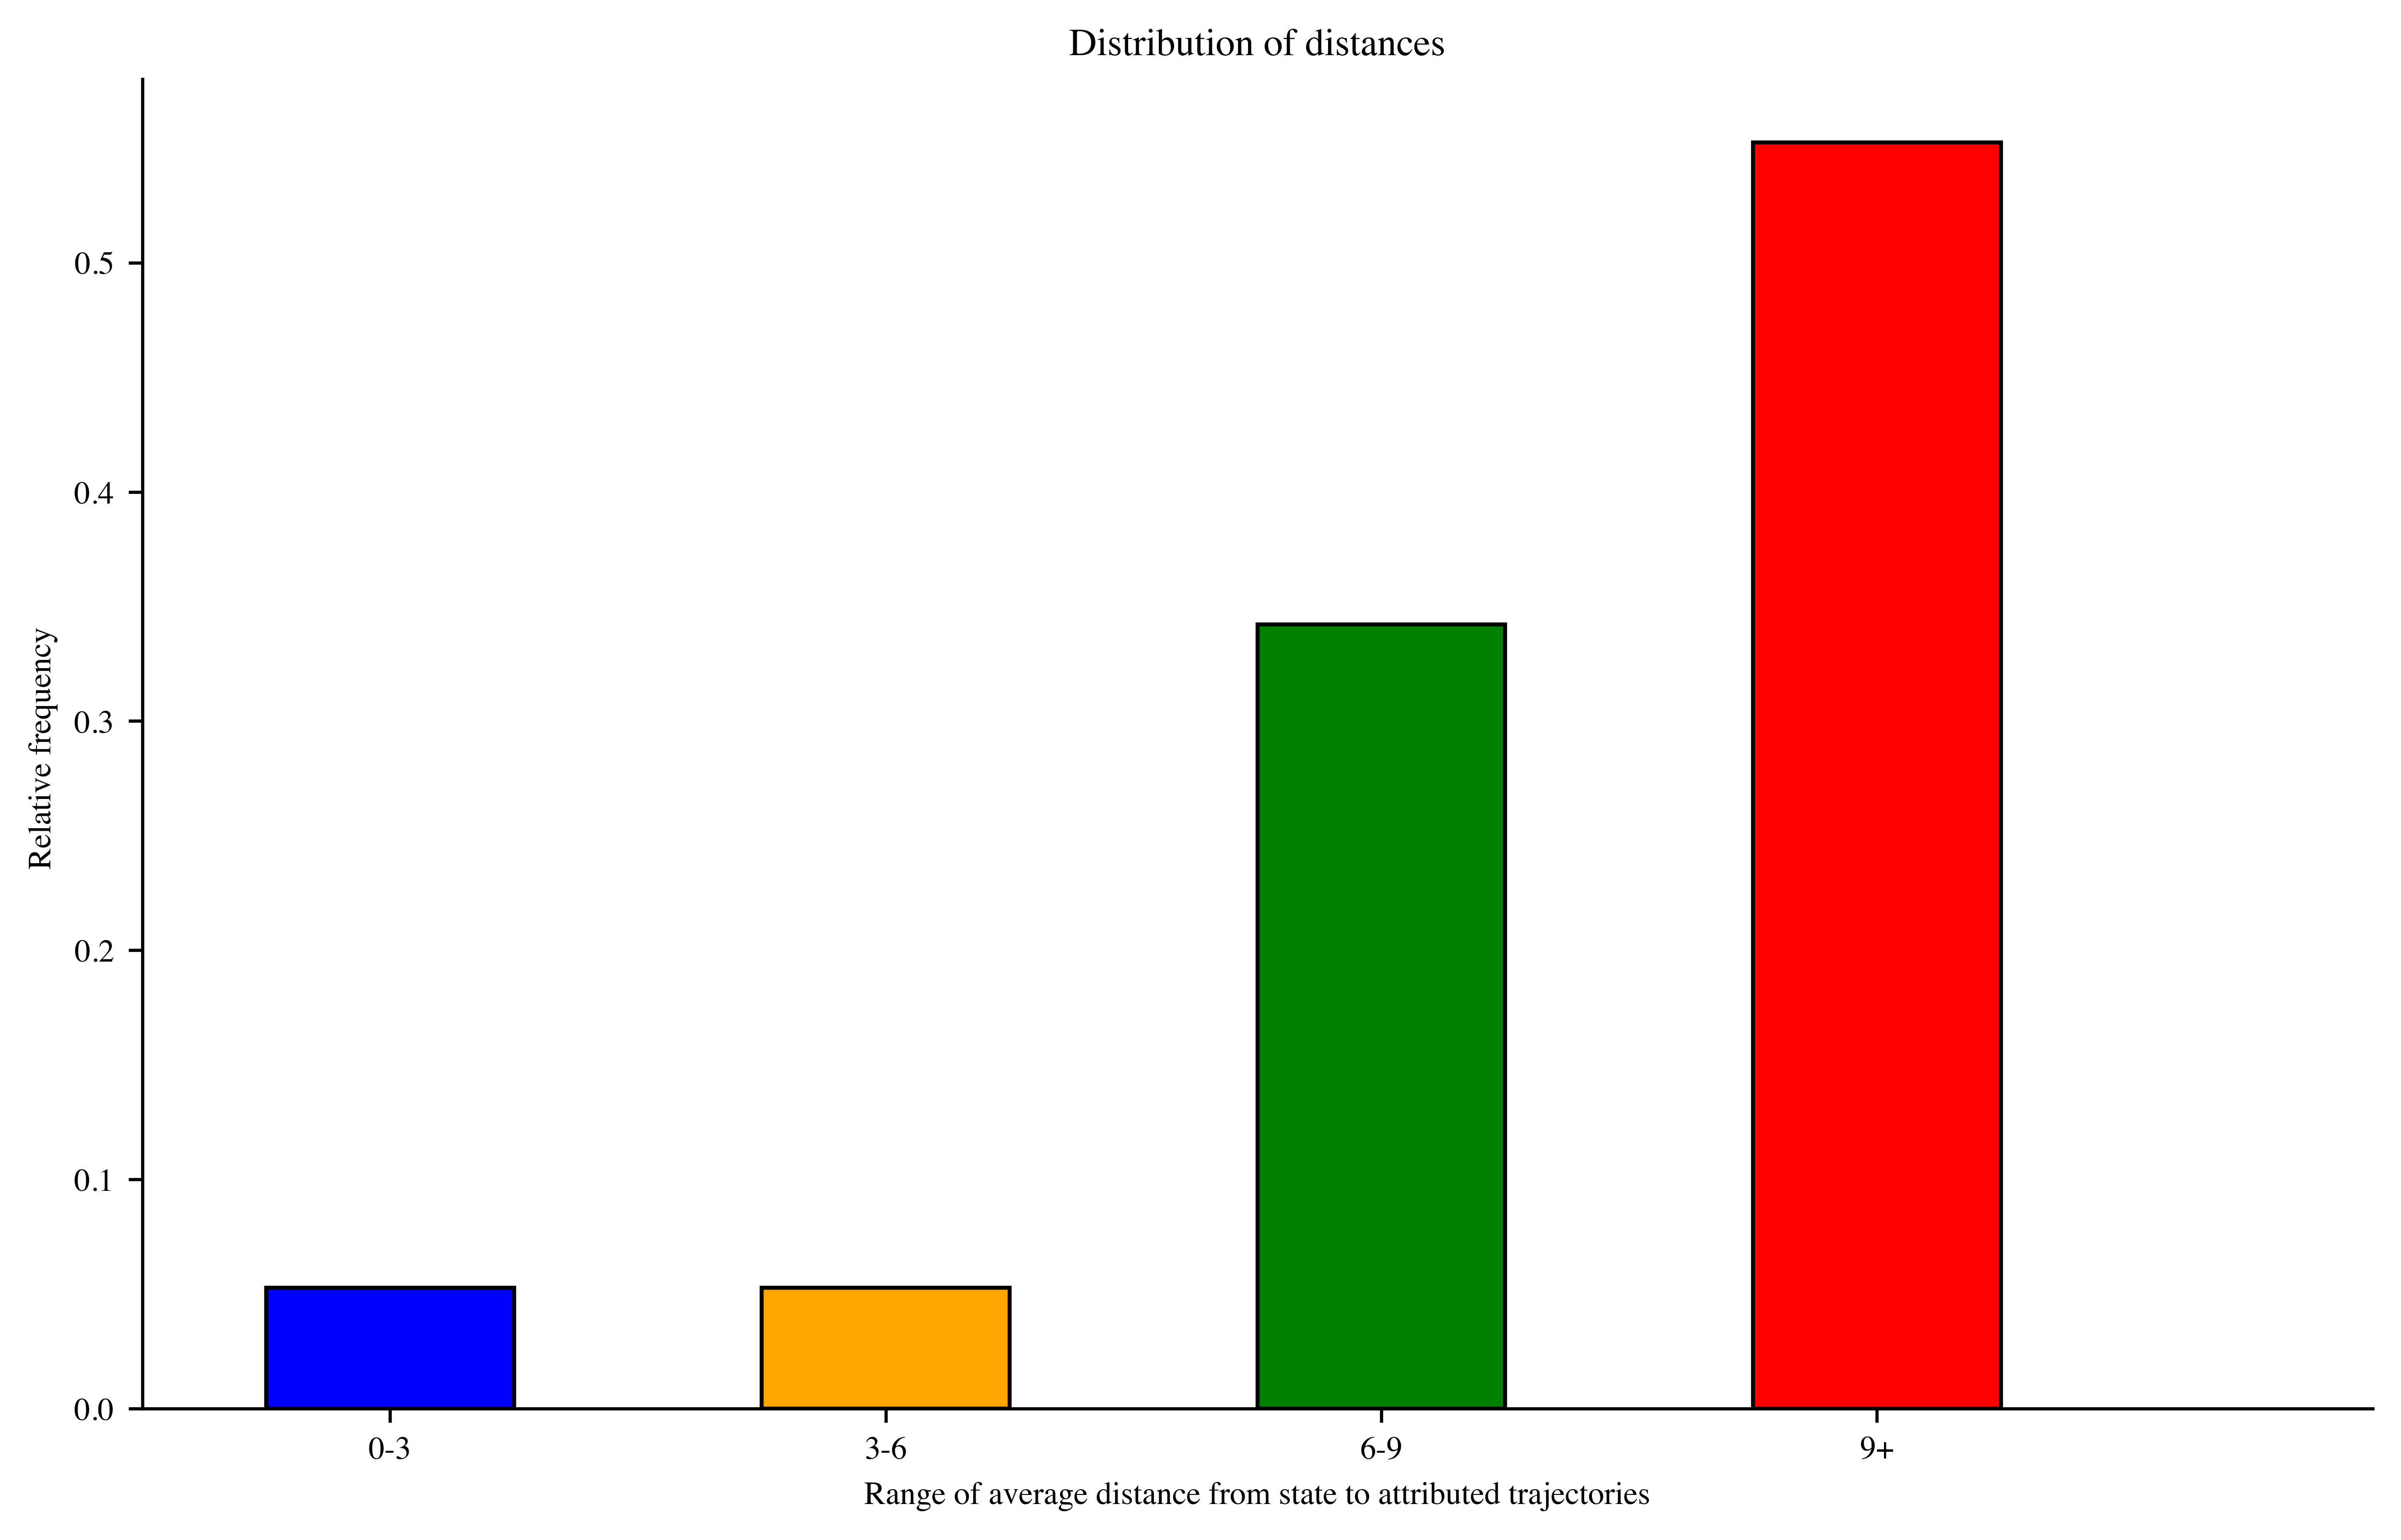

In [69]:
import matplotlib.pyplot as plt
import numpy as np
# I want the vertical axis to be the relative frequency, not the absolute frequency


# Data provided for lengths
lengths = [x for x in database_length_distances.values()]

# Binning the data
#new_bins = [0, 3, 6, 9, max(lengths)]
new_bins = [0,3,6,9,max(lengths)]
bin_labels = ['0-3', '3-6', '6-9', '9+']
bin_centers = [0.5, 1.5, 2.5, 3.5]  # Centers of the bins for labeling
colors = ['blue', 'orange', 'green', 'red']

# Counting occurrences in each bin range

counts, _ = np.histogram(lengths, bins=new_bins)
relative_freq = counts / sum(counts)
# Creating the bar plot with specified requirements
plt.figure(figsize=(10,6))
bar_width = 0.5  # Narrower width for bars
for i, count in enumerate(relative_freq):
    plt.bar(bin_centers[i], count, color=colors[i], edgecolor='black', width=bar_width)

plt.title('Distribution of distances')
plt.xlabel('Range of average distance from state to attributed trajectories')
plt.ylabel('Relative frequency ')
plt.xticks(bin_centers, bin_labels)
plt.xlim(0, max(bin_centers) + 1)  # Reducing the length of the x-axis

plt.show()





# Additional Experiments for RTISV

We investigate if there is a correlation between trajectories and lower state value. It correspondds to the additional experiments for RTISV in the paper.

In [72]:
# count for each cluster how many times it is attributed
cluster_attr_freq = {(i+1):0 for i in range(len(clusters))}
print(cluster_attr_freq)

for attribution in attributions:
    #access the responsible cluster
    index = attribution['responsible_cluster']
    #add 1 to the key that has that index
    cluster_attr_freq[index+1] += 1
   

print(cluster_attr_freq)
frequencies = list(cluster_attr_freq.values())
print(frequencies)

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
{1: 13, 2: 0, 3: 0, 4: 1, 5: 3, 6: 1, 7: 2, 8: 4, 9: 6, 10: 8}
[13, 0, 0, 1, 3, 1, 2, 4, 6, 8]


In [73]:
# sorted_result is the list with the action values for each data combination. We now want to analyze if there is a correlation between how many times a cluster is attributed and the action values for that cluster
print(results)
#eliminate the first element
results.pop(0)
print(results)

[0.44332855386268, 0.36410422563212047, 0.43859771440384204, 0.44332855385999964, 0.4396586059040094, 0.43335082124679675, 0.43860570238383007, 0.4393743756087195, 0.4279891971757072, 0.4220649234628607, 0.4307583770727887]
[0.36410422563212047, 0.43859771440384204, 0.44332855385999964, 0.4396586059040094, 0.43335082124679675, 0.43860570238383007, 0.4393743756087195, 0.4279891971757072, 0.4220649234628607, 0.4307583770727887]


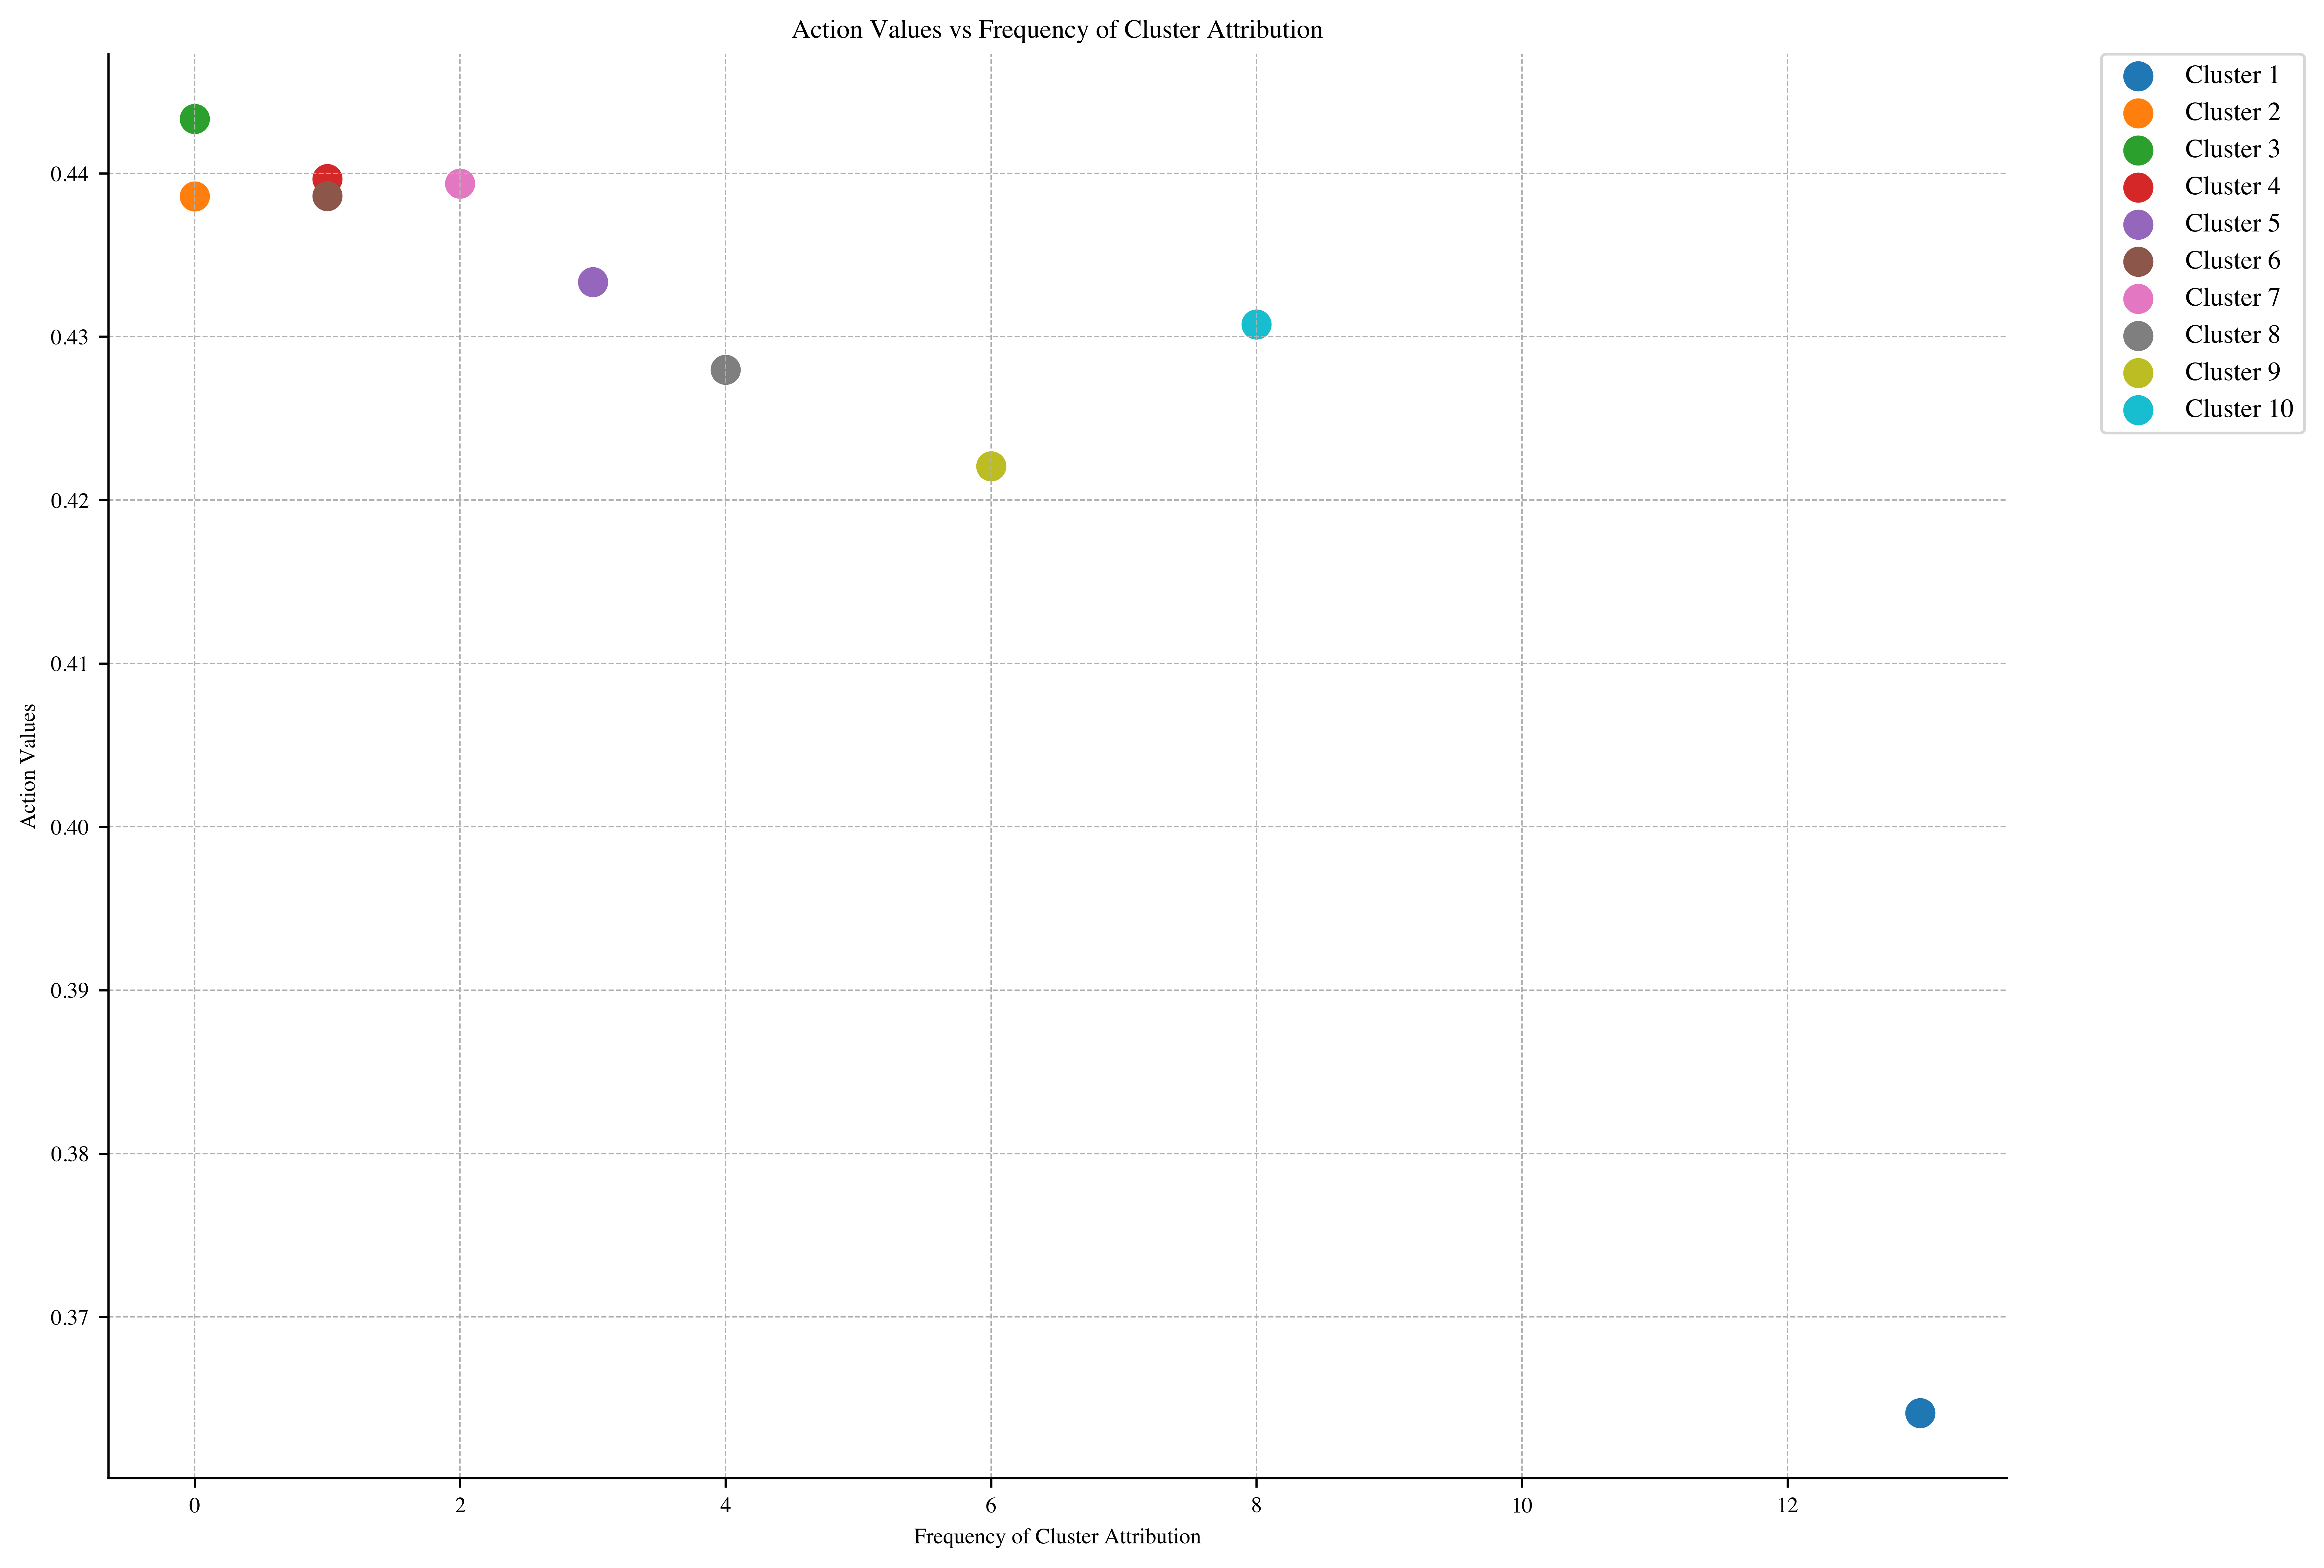

In [74]:

# Extract frequencies corresponding to the elements in 'results'

# Create scatter plot
# Create scatter plot with annotations and different colors
# Set a reasonable figure size to avoid too large image dimensions

# Set a reasonable figure size to avoid too large image dimensions
plt.figure(figsize=(14, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_results)))

# Scatter plot without log scale since it was causing issues
for i, (x, y, color) in enumerate(zip(frequencies,results, colors), start=1):
    plt.scatter(x, y, label=f'Cluster {i}', color=color, s=100)  # Increase marker size
    

# Labels and title with updated non-logarithmic labels
plt.xlabel('Frequency of Cluster Attribution')
plt.ylabel('Action Values')
plt.title('Action Values vs Frequency of Cluster Attribution')

# Legend with increased font size for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='large')

# Show grid
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Tight layout for the figure with space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show plot
plt.show()

In [75]:
# length of each cluster
cluster_lengths = {i+1:len(cluster) for i, cluster in enumerate(clusters)}

In [76]:
print(cluster_lengths)

{1: 215, 2: 28, 3: 2, 4: 13, 5: 8, 6: 9, 7: 1, 8: 11, 9: 5, 10: 8}
